In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import graph_policy
graph_policy.VARIABLE_NUM = 10

In [3]:
from graph_policy import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 64

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from models/activepolicy-18-03-28-122105/model-10000064


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 10

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")
#import sys
#logfile = sys.stdout

class RealDPLL(object):
    def __init__(self):
        self.number_of_runs = 0
        self.number_of_errors = 0

    def run(self, cnf: CNF, heur:bool=False):
        assert isinstance(cnf, CNF)

        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None
        
        if heur:
            for cls in cnf.clauses:
                if len(cls) == 1:
                    sug_var = cls[0]
                    #print("for {} unit-clause {}".format(cnf, sug_var))
                    sug_cnf = cnf.set_var(sug_var)
                    sug_res = self.run(sug_cnf, heur)
                    return None if sug_res is None else [sug_var] + sug_res

            c = set(svar for cls in cnf.clauses for svar in cls)
            for var in cnf.vars:
                if (var in c) != (-var in c):
                    sug_var = var if var in c else -var
                    #print("for {} pure-literal {}".format(cnf, sug_var))
                    sug_cnf = cnf.set_var(sug_var)
                    sug_res = self.run(sug_cnf, heur)
                    return None if sug_res is None else [sug_var] + sug_res
                
        
        self.number_of_runs += 1
        sug_var = self.suggest(cnf)
        sug_cnf = cnf.set_var(sug_var)

        sug_res = self.run(sug_cnf, heur)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf, heur)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None

    def suggest(self, cnf):
        return next(iter(cnf.vars))

class GraphBasedRealDPLL(RealDPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        #print("for {} suggesting {}".format(input_cnf, best_svar))
        return best_svar

In [13]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [14]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [15]:
def print_all(s, k, n, m):
    global S, K, N, M
    S = s
    K = k
    N = n
    M = m
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_random_kcnf(K, N, M)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    #compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

In [16]:
K = 3
N = 2
M = 8
sat = get_random_kcnf(K, N, M)
print(sat)

dpll = GraphBasedRealDPLL()
solution = dpll.run(sat, heur=True)
print()
print("with heur")
print("Solution:", solution)
print(dpll.number_of_runs)

dpll = GraphBasedRealDPLL()
solution = dpll.run(sat, heur=False)
print()
print("without heur")
print("Solution:", solution)
print(dpll.number_of_runs)

(~a|a|~b)&(~b|~b|a)&(b|b|a)&(a|~a|~b)&(~a|b|a)&(~a|a|a)&(~b|b|~a)&(a|a|~b)

with heur
Solution: [2, 1]
1

without heur
Solution: [2, 1]
2


In [17]:
import numpy as np

In [18]:
def get_stats(sats, heur):
    runs = []
    for sat in sats:
        dpll = GraphBasedRealDPLL()
        solution = dpll.run(sat, heur=heur)
        runs.append(dpll.number_of_runs)
    return np.mean(runs), np.median(runs)

In [19]:
K = 3
N = 2
M = 8
SAMPLE = 1
sats = [get_random_kcnf(K, N, M) for i in range(SAMPLE)]

print(get_stats(sats, True))

print(get_stats(sats, False))

(1.0, 1.0)
(2.0, 2.0)


In [20]:
K = 3
SAMPLE = 10

Ns = range(1, 10)
Ms = [N*4 for N in Ns]
ResWH = []
ResNH = []
for N, M in zip(Ns, Ms):
    sats = [get_random_kcnf(K, N, M) for i in range(SAMPLE)]
    resh = get_stats(sats, True)
    resn = get_stats(sats, False)
    ResWH.append(resh)
    ResNH.append(resn)
    print(N)
    print("\t Heur", resh)
    print("\t NoHe", resn)

1
	 Heur (1.0, 1.0)
	 NoHe (1.0, 1.0)
2
	 Heur (1.3, 1.0)
	 NoHe (2.1, 2.0)
3
	 Heur (1.4, 1.0)
	 NoHe (2.9, 3.0)
4
	 Heur (1.7, 1.5)
	 NoHe (4.1, 4.0)
5
	 Heur (2.3, 2.0)
	 NoHe (7.9, 5.0)
6
	 Heur (2.3, 2.0)
	 NoHe (6.6, 6.0)
7
	 Heur (2.4, 2.0)
	 NoHe (8.0, 7.0)
8
	 Heur (2.5, 2.5)
	 NoHe (11.9, 8.0)
9
	 Heur (4.4, 3.5)
	 NoHe (25.1, 9.0)


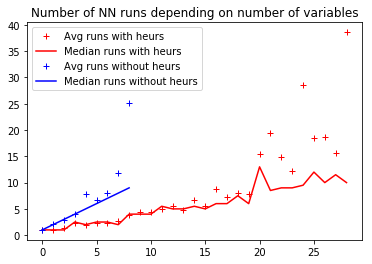

In [28]:
plt.plot([el[0] for el in ResWH], "r+", label='Avg runs with heurs')
plt.plot([el[1] for el in ResWH], "r", label='Median runs with heurs')
plt.plot([el[0] for el in ResNH], "b+", label='Avg runs without heurs')
plt.plot([el[1] for el in ResNH], "b", label='Median runs without heurs')
plt.title("Number of NN runs depending on number of variables")
plt.legend()
plt.show()

In [22]:
K = 3
SAMPLE = 10

Ns = range(1, 30)
Ms = [N*4 for N in Ns]
ResWH = []
for N, M in zip(Ns, Ms):
    sats = [get_random_kcnf(K, N, M) for i in range(SAMPLE)]
    resh = get_stats(sats, True)
    ResWH.append(resh)
    print(N)
    print("\t Heur", resh)

1
	 Heur (1.0, 1.0)
2
	 Heur (1.0, 1.0)
3
	 Heur (1.3, 1.0)
4
	 Heur (2.4, 2.5)
5
	 Heur (2.0, 2.0)
6
	 Heur (2.4, 2.5)
7
	 Heur (2.4, 2.5)
8
	 Heur (2.7, 2.0)
9
	 Heur (3.9, 4.0)
10
	 Heur (4.4, 4.0)
11
	 Heur (4.4, 4.0)
12
	 Heur (4.9, 5.5)
13
	 Heur (5.6, 5.0)
14
	 Heur (4.8, 5.0)
15
	 Heur (6.6, 5.5)
16
	 Heur (5.5, 5.0)
17
	 Heur (8.8, 6.0)
18
	 Heur (7.3, 6.0)
19
	 Heur (8.1, 7.5)
20
	 Heur (7.9, 6.0)
21
	 Heur (15.5, 13.0)
22
	 Heur (19.5, 8.5)
23
	 Heur (14.8, 9.0)
24
	 Heur (12.2, 9.0)
25
	 Heur (28.5, 9.5)
26
	 Heur (18.4, 12.0)
27
	 Heur (18.6, 10.0)
28
	 Heur (15.6, 11.5)
29
	 Heur (38.6, 10.0)


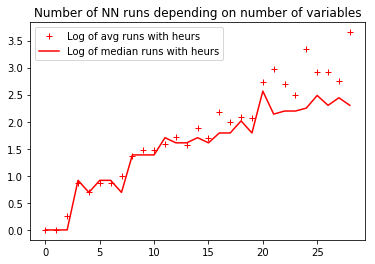

In [23]:
plt.plot([np.log(el[0]) for el in ResWH], "r+", label='Log of avg runs with heurs')
plt.plot([np.log(el[1]) for el in ResWH], "r", label='Log of median runs with heurs')
plt.title("Number of NN runs depending on number of variables")
plt.legend()
plt.show()

In [24]:
degs = np.polyfit(range(1, 10), [np.log(el[1]) for el in ResNH], deg=1)
degs

array([0.251, 0.168])

In [25]:
def poly(degs, x):
    if len(degs) == 0:
        return 0.0
    else:
        return poly(degs[:-1], x) * x + degs[-1]

In [29]:
degs = np.polyfit(Ns, [np.log(el[1]) for el in ResWH], deg=2)
degs

degss = [np.polyfit(Ns, [np.log(el[1]) for el in ResWH], deg=X) for X in range(4)]
degss

[array([1.545]),
 array([0.083, 0.299]),
 array([-0.003,  0.168, -0.139]),
 array([ 0.   , -0.007,  0.216, -0.27 ])]

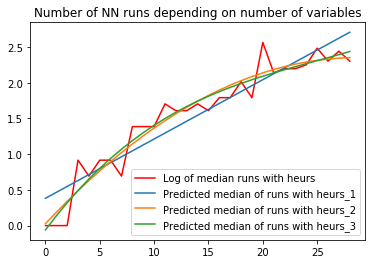

In [32]:

plt.plot([np.log(el[1]) for el in ResWH], "r", label='Log of median runs with heurs')
for X in range(1, 4):
    plt.plot([poly(degss[X], N) for N in Ns], label='Predicted median of runs with heurs_{}'.format(X))
plt.title("Number of NN runs depending on number of variables")
plt.legend()
plt.show()